In [3]:
# Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import joblib  # For model saving


# Load Dataset
df = pd.read_csv('creditcard.csv')

In [4]:
# Data Exploration
print(df.head())
print(df.info())
print(df.describe())

# Check for missing values
missing = df.isnull().sum()
print("Missing values:\n", missing)

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

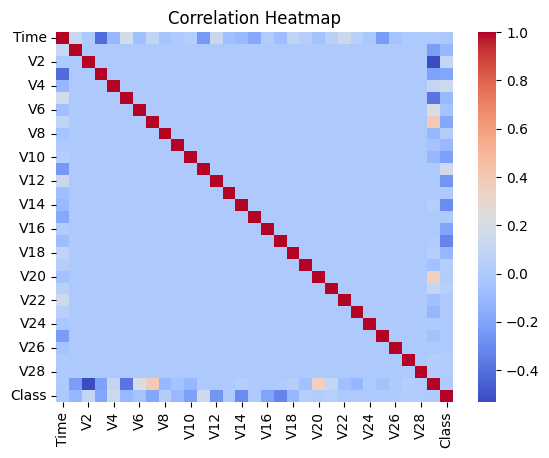

In [5]:
# Data Visualization
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.title('Correlation Heatmap')
plt.show()

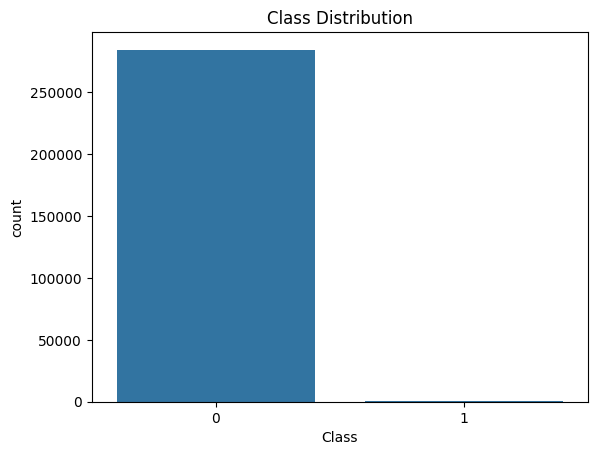

In [6]:
# Class distribution
sns.countplot(x='Class', data=df)
plt.title('Class Distribution')
plt.show()

In [7]:
# Feature Scaling
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])
df['Time'] = scaler.fit_transform(df[['Time']])

In [8]:
# Data Splitting
X = df.drop('Class', axis=1)
y = df['Class']

In [9]:
# Balancing the Dataset with SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

In [10]:
# Splitting into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)


In [11]:
# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

In [12]:
# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [13]:
# Optimized SVM Implementation

# Step 1: Scaling the Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Dimensionality Reduction with PCA
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Step 3: Hyperparameter Tuning for Linear Kernel SVM
param_grid = {
    'C': [0.1, 1, 10]  # Regularization parameter
}

linear_svm = LinearSVC(max_iter=10000)
grid_search = GridSearchCV(linear_svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_pca, y_train)

# Best Linear SVM Model
best_linear_svm = grid_search.best_estimator_
print(f"Best Parameters for Linear SVM: {grid_search.best_params_}")

# Step 4: Training and Predicting with Best Model
best_linear_svm.fit(X_train_pca, y_train)
y_pred_svm = best_linear_svm.predict(X_test_pca)

Best Parameters for Linear SVM: {'C': 1}


In [14]:
# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

C:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:20:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [15]:
# Neural Network
nn = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

C:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
9951/9951 ━━━━━━━━━━━━━━━━━━━━ 11s 951us/step - accuracy: 0.9635 - loss: 0.0910 - val_accuracy: 0.9975 - val_loss: 0.0106
Epoch 2/10
9951/9951 ━━━━━━━━━━━━━━━━━━━━ 9s 923us/step - accuracy: 0.9952 - loss: 0.0167 - val_accuracy: 0.9987 - val_loss: 0.0061
Epoch 3/10
9951/9951 ━━━━━━━━━━━━━━━━━━━━ 9s 920us/step - accuracy: 0.9969 - loss: 0.0112 - val_accuracy: 0.9988 - val_loss: 0.0052
Epoch 4/10
9951/9951 ━━━━━━━━━━━━━━━━━━━━ 9s 923us/step - accuracy: 0.9974 - loss: 0.0101 - val_accuracy: 0.9992 - val_loss: 0.0052
Epoch 5/10
9951/9951 ━━━━━━━━━━━━━━━━━━━━ 9s 927us/step - accuracy: 0.9978 - loss: 0.0087 - val_accuracy: 0.9995 - val_loss: 0.0037
Epoch 6/10
9951/9951 ━━━━━━━━━━━━━━━━━━━━ 9s 936us/step - accuracy: 0.9981 - loss: 0.0080 - val_accuracy: 0.9993 - val_loss: 0.0036
Epoch 7/10
9951/9951 ━━━━━━━━━━━━━━━━━━━━ 10s 979us/step - accuracy: 0.9983 - loss: 0.0070 - val_accuracy: 0.9995 - val_loss: 0.0032
Epoch 8/10
9951/9951 ━━━━━━━━━━━━━━━━━━━━ 9s 943us/step - accuracy: 0.9983

In [16]:
# Neural Network Predictions
y_pred_nn = (nn.predict(X_test) > 0.5).astype("int32")

5331/5331 ━━━━━━━━━━━━━━━━━━━━ 4s 647us/step


In [17]:
# Model Evaluation
def evaluate_model(y_test, y_pred, model_name):
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred)}")
    print(f"Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}\n")

models = {
    "Logistic Regression": y_pred_log,
    "Random Forest": y_pred_rf,
    "SVM": y_pred_svm,
    "XGBoost": y_pred_xgb,
    "Neural Network": y_pred_nn
}

for model, y_pred in models.items():
    evaluate_model(y_test, y_pred, model)

Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     85149
           1       0.97      0.92      0.95     85440

    accuracy                           0.95    170589
   macro avg       0.95      0.95      0.95    170589
weighted avg       0.95      0.95      0.95    170589

ROC-AUC Score: 0.9471028754980859
Confusion Matrix:
 [[83083  2066]
 [ 6966 78474]]

Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85149
           1       1.00      1.00      1.00     85440

    accuracy                           1.00    170589
   macro avg       1.00      1.00      1.00    170589
weighted avg       1.00      1.00      1.00    170589

ROC-AUC Score: 0.9998943029278089
Confusion Matrix:
 [[85131    18]
 [    0 85440]]

Classification Report for SVM:

              precision    recall  f1-score   support


AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

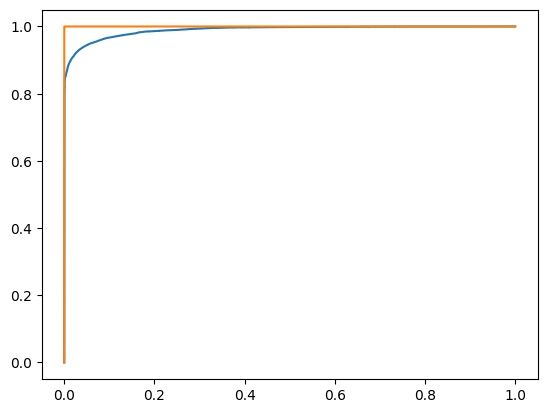

In [18]:
# Visualizing ROC Curves
for model_name, model in zip(models.keys(), [log_reg, rf, best_linear_svm, xgb, nn]):
    if model_name != "Neural Network":
        probs = model.predict_proba(X_test)[:, 1]
    else:
        probs = nn.predict(X_test).flatten()
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=model_name)

plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

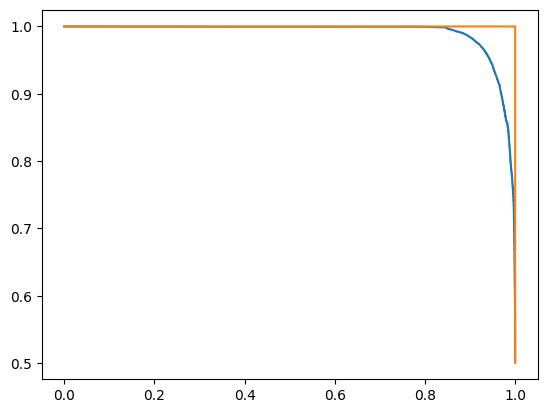

In [19]:
# Precision-Recall Curve
for model_name, model in zip(models.keys(), [log_reg, rf, best_linear_svm, xgb, nn]):
    if model_name != "Neural Network":
        probs = model.predict_proba(X_test)[:, 1]
    else:
        probs = nn.predict(X_test).flatten()
    precision, recall, _ = precision_recall_curve(y_test, probs)
    plt.plot(recall, precision, label=model_name)

plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

In [20]:
# Save Models
joblib.dump(log_reg, 'logistic_regression_model.pkl')
joblib.dump(rf, 'random_forest_model.pkl')
joblib.dump(best_linear_svm, 'svm_model.pkl')
joblib.dump(xgb, 'xgboost_model.pkl')
nn.save('neural_network_model.h5')

print("All models saved successfully!")

All models saved successfully!


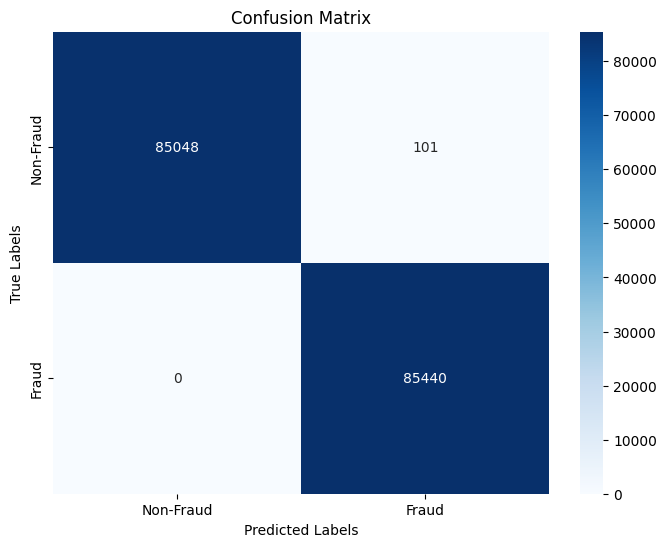

              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     85149
       Fraud       1.00      1.00      1.00     85440

    accuracy                           1.00    170589
   macro avg       1.00      1.00      1.00    170589
weighted avg       1.00      1.00      1.00    170589



In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Replace with your actual test labels and predictions
# y_test = [...]  # Actual labels
# y_pred = [...]  # Predicted labels

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print classification report for additional metrics
print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))
